# Autoencoder and Variational Autoencode
本單元，我們將帶領各位實作非監督式學習中相當重要的神經網路模型及其變形。

## 1. 初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Keras functions\n",
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Activation, Lambda, concatenate
from keras.optimizers import SGD

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train/255
x_test = x_test/255

## 2. Autoencoder
Autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，是由一編碼器(Encode)與一解碼器(Decoder)所結合而成的函數。

用數學符號表示，這個模型可以寫成：

$$ \\{R}^n -Encoder-> {R}^m- Decoder-> {R}^n$$
$$ x -Encoder-> h- Decoder-> \hat{x}$$

其中，$m<n$，$x$ $\approx$ $\\\hat{x}$ = Decoder(h) = Decoder(Encoder(x))，$h$ 被稱之為 latent 變數，或稱 $x$ 的 latent 表示。

換言之，我們希望原本的資料 $x$，經過函數 $Encoder$ (編碼器) 編碼成維度比較小的資料 $h$，再透過函數 $Decoder$ (解碼器)，還原成 $\hat{x}$。

其中，$m<n$ 代表的是，資料編碼後所剩的資訊是能用於還原的重要資訊/特徵，而  $x$ $\approx$ $\hat{x}$ 代表可還原資料。

一般而言，我們會希望 $Encoder$ 和 $Decoder$ 看起來有點對稱。

## 2.1 Autoencoder 與手寫辨識資料 MNIST
在這裡，我們考慮使用 Autoencoder 模型壓縮並還原 MNIST 手寫辨識資料。

因此， $n=28x28=784$，且我們希望壓縮後的維度為 $2$，且隱藏層的神經元數量為 100。

本單元所建構的的 Autoencoder 結構如下:

![圖](autoencoder.png)

In [6]:
enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid') ## activation 使用 sigmoid，就能將 $h$ 限制在 $[0, 1]\\times[0, 1]$ 之間

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

接著，定義層前後變數之間的關係；首先，第一個變數必定以 `Input` 函數來定義

In [7]:
x = Input(shape=(784,))

$$ x -> enc_x -> h -> dec_x -> \hat{x}$$

In [8]:
enc_x = enc_1(x)
h = enc_2(enc_x)

dec_x = dec_2(h)
x_reconstructed = dec_1(dec_x)

In [9]:
autoencoder = Model(x, x_reconstructed)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.compile(loss='kullback_leibler_divergence', optimizer='Nadam',metrics=["accuracy"])

In [11]:
# autoencoder.fit(x_train, x_train, batch_size=32, epochs=100)

In [12]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

## 2.2 視覺化 - 子模型的取出

為了視覺化(及其他潛在應用)，我們也會從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

$$Autoencoder: x -> enc_x -> h -> dec_x -> \hat{x}$$
$$Encoder: x -> enc_x -> h$$
$$Decoder: h -> dec_x -> \hat{x}$$

In [13]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


由於 Decoder 是從 $h$ 往後兩層，因此，我們需要先定義一個同樣大小的 `Input`

In [14]:
h_input = Input(shape=(2,))

Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## 2.3 視覺化 - Encoder

在建構 Autoencoder 時，我們設定 $h$ 的維度為 $2$ 是為了視覺化上的呈現，本小節將介紹如何操作神經網路來視覺化手寫辨識資料 MNIST。

首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示

In [15]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 14313 圖的 latent 表示為 [[0.1981842 0.3660251]]


接者，我們從 $10000$ 筆測試資料隨機挑選 $1000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。

In [16]:
idices = np.random.randint(x_test.shape[0], size=1000)

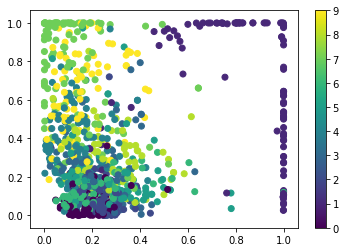

In [17]:
latents = Encoder.predict(x_test[idices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test[idices])
plt.colorbar()
plt.show()

## 2.4 視覺化 - Decoder

首先，我們在 $[0, 1] X [0, 1]$ 這個單位正方形內均勻取樣 $15*15$ 個點，並將這 $225$ 個平面上的點，透過 Decoder 進行圖片的還原。

In [18]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [19]:
for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = Decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

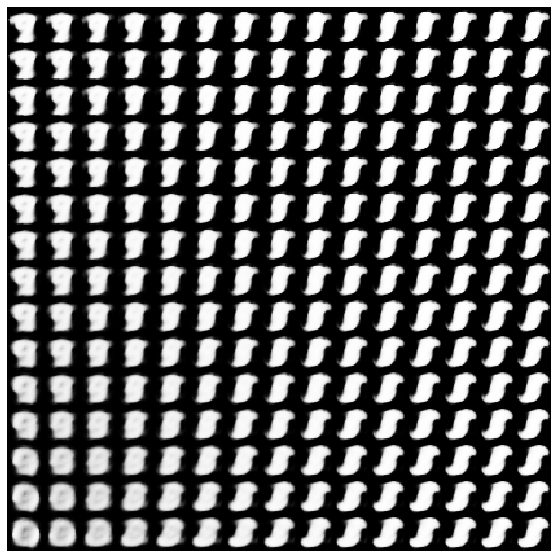

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## 3 Variational Autoencoder

Autoencoder 是將每筆資料壓縮成 latent 表示後再進行還原。

以手寫辨識資料 MNIST 為例，由於壓縮的方式是確定的，因此，每張手寫圖片的 latent 表示是固定的。

換句話說，Autoencoder 只是一種將資料(以其 latent)適當的擺放的函數。

如果每筆資料的 latent 不僅僅是一個固定的位置，而是希望在這個 latent 附近，都能和還原的差不多，那我們應該怎麼做呢？

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

本節我們準備建構的 Variational Autoencoder 的結構如下：

![圖](variational_autoencoder.png)

## 3.2 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [21]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [22]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [23]:
def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
        return z_mean + K.exp(z_log_var / 2) * epsilon

In [24]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [25]:
dec_x = dec_2(z)
x_reconstructed = dec_1(dec_x)

In [26]:
VAE = Model(x, x_reconstructed)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 3.3 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

In [27]:
from keras import metrics

In [28]:
def vae_loss(x, x_recon): 
        recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return recovery_loss + kl_loss

## 3.4 訓練 VAE

In [29]:
VAE.compile(loss=vae_loss, optimizer='Nadam')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
# VAE.fit(x_train, x_train, batch_size=32, epochs=100)

In [31]:
# VAE.save_weights('VAE_handwriting_model_weights.h5')
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 3.5 VAE 的視覺化呈現
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

$$Autoencoder: x -> enc_x -> h -> dec_x ->  \hat{x}$$
$$Encoder: enc_x -> \mu\ $$
$$Decoder: dec_x -> \hat{x}$$

In [32]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [33]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現

In [34]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 43141 圖的 latent 表示為 [[ 0.3286798 -1.0208107]]


In [35]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

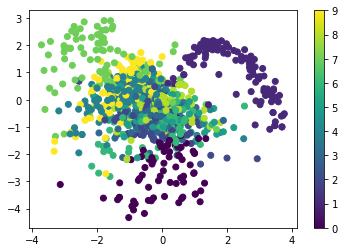

In [36]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[indices])
plt.colorbar()
plt.show()

In [37]:
def normalize_to_unit(x):
        x -= x.min()
        x /= x.max()
        return x

In [38]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                    j * digit_size: (j + 1) * digit_size] = normalize_to_unit(digit)

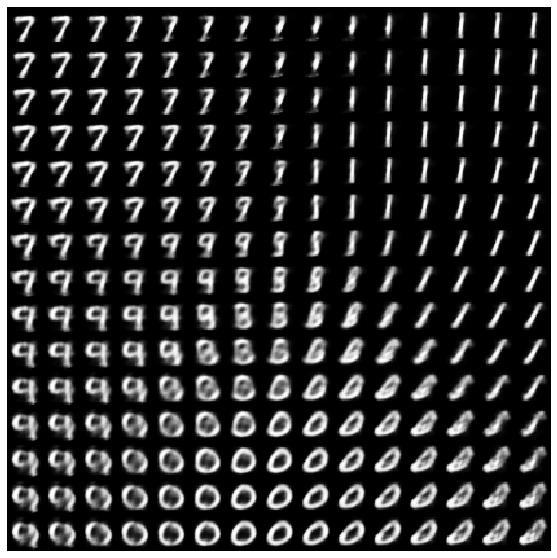

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## 3.6 與 Autoencoder 的 Encoder 視覺化進行比較

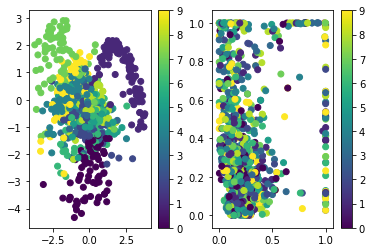

In [40]:
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[indices])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test[indices])
plt.colorbar()
plt.show()

恭喜你，完成學習並建立 Variational Autoencoder 及神經網路的基本視覺化呈現。
Variational Autoencoder (VAE) 是一個重要的非監督式學習模型，具體應用的場合為特徵抽取/資料壓縮及還原，為影像處理中常見的模型之一。

恭喜各位已經完成了學習，在本單元的練習中，我們希望各位嘗試建立並訓練屬於自己的 VAE。